# SU2020 track cuts

simplified for presentation

## Preamble

In [1]:
# External packages
import sys
import warnings
warnings.filterwarnings("ignore") # suppress warnings
import matplotlib.pyplot as plt
import awkward as ak

# pyutils classes
from pyutils.pylogger import Logger
from pyutils.pyplot import Plot
from pyutils.pyselect import Select

# mu2e-cosmic classes
sys.path.extend(["../../src/utils", "../../src/core"])
from io_manager import Load
from analyse import Analyse # just for pitch angle

logger = Logger()

## Load data

Compare au and aw 

In [2]:
datasets = ["Cosmics", "Signal"]

In [3]:
!ls -ltrh ../../../output/results/

total 0
drwxr-xr-x. 2 sgrant fnalgrid 7 Aug  5 07:38 ana_alpha_CRYOffspill-LH_as


In [4]:
ana_labels = {
    # datasets[0]: "preselection_CRY_onspill-LH_aq",
    datasets[0]: "preselection_CRY_onspill-LH_au",
    # datasets[1]: "preselection_CRY_onspill-LH_aw",
    # datasets[3]: "preselection_signal_onspill-LH_aq",
    datasets[1]: "preselection_signal_onspill-LH_au",
    # datasets[3]: "preselection_signal_onspill-LH_aw",
}

results = {}
for key, ana_label in ana_labels.items():
    loader = Load(
        in_path = f"../../output/results/{ana_label}"
    )
    results[key] = loader.load_pkl()     

[Load] ✅ Initialised with out_path=../../output/results/preselection_CRY_onspill-LH_au
[Load] ✅ Successfully loaded results from ../../output/results/preselection_CRY_onspill-LH_au/results.pkl
[Load] ✅ Initialised with out_path=../../output/results/preselection_signal_onspill-LH_au
[Load] ✅ Successfully loaded results from ../../output/results/preselection_signal_onspill-LH_au/results.pkl


## Cutflow

In [5]:
for label, result in results.items(): 
    logger.log(label, "info")
    display(result["cut_flow"].round(3))

[pylogger] ⭐️ Cosmics


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,267495,100.000,100.000,No selection applied
1,has_trk_front,Preselect,267265,99.914,99.914,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,256419,95.859,95.942,Electron track fits
3,is_downstream,Preselect,155733,58.219,60.734,Downstream tracks (p_z > 0 at tracker entrance)
4,one_reco_electron,Preselect,111853,41.815,71.824,One reco electron / event
5,is_truth_electron,Preselect,33212,12.416,29.693,Track parents are electrons (truth PID)


[pylogger] ⭐️ Signal


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,145542,100.000,100.000,No selection applied
1,has_trk_front,Preselect,145509,99.977,99.977,Tracks intersect tracker entrance
2,is_reco_electron,Preselect,142980,98.240,98.262,Electron track fits
3,is_downstream,Preselect,142970,98.233,99.993,Downstream tracks (p_z > 0 at tracker entrance)
4,one_reco_electron,Preselect,142591,97.972,99.735,One reco electron / event
5,is_truth_electron,Preselect,142591,97.972,100.000,Track parents are electrons (truth PID)


In [6]:


# from pyutils.pyprint import Print
# printer = Print()

# printer.print_n_events(results["CRY MDC2020au"]["events"])

## Select tracker front

In [7]:
# help(selector.select_surface)

In [8]:
# Filter tracker entrance
selector = Select()

# Applies to results[dataset]["events"]
def surface_cut(arr, surface_name="TT_Front"): 
    # for label, result in results.items():
    # Copy
    arr_cut = ak.copy(arr)
    # Track front 
    at_trk_front = selector.select_surface(arr_cut["trkfit"], surface_name=surface_name) # trksegs-level
    has_trk_front = ak.any(at_trk_front, axis=-1)
    # Cut
    # arr_cut["trk"] = arr_cut["trk"][at_trk_front]
    arr_cut["trkfit"] = arr_cut["trkfit"][at_trk_front]
    # Then clean up events with no tracks after cuts
    arr_cut = arr_cut[ak.any(has_trk_front, axis=-1)]
    # Return filtered array
    return arr_cut

results_BK = results.copy()
for label, result in results.items():
    results[label]["events"] = surface_cut(results[label]["events"], "TT_Front") # "TT_Mid")

[pyselect] ✅ Returning mask for trksegs with sid = 0
[pyselect] ✅ Returning mask for trksegs with sid = 0


## Array flattener

In [9]:
# results["CRY MDC2020au"]["events"].keys()

In [10]:
analyse = Analyse() 

def get_flat_arrays(results, labels=None):
    
    # Init arrays (a bit ugly but whatever)
    trkqual, nactive, t0err, d0, lhr_max, pitch_angle = {}, {}, {}, {}, {}, {}
    # Loop through results
    for label, result in results.items(): 
        if labels is not None and label not in labels: 
            continue
        # flatten 
        trkqual[label] = ak.flatten(result["events"]["trk"]["trkqual.result"], axis=None)
        nactive[label] = ak.flatten(result["events"]["trk"]["trk.nactive"], axis=None)
        t0err[label] = ak.flatten(result["events"]["trkfit"]["trksegpars_lh"]["t0err"], axis=None)
        d0[label] = ak.flatten(result["events"]["trkfit"]["trksegpars_lh"]["d0"], axis=None)
        lhr_max[label] = ak.flatten(result["events"]["trkfit"]["trksegpars_lh"]["maxr"], axis=None)
        
        pitch_angle[label] = ak.flatten(analyse.get_pitch_angle(result["events"]["trkfit"]), axis=None)

    return trkqual, nactive, t0err, d0, lhr_max, pitch_angle

trkqual, nactive, t0err, d0, lhr_max, pitch_angle = get_flat_arrays(results)


[pyvector] ⭐️ Initialised Vector with verbosity = 1
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Analyse] ⭐️ Initialised with:
  on_spill        = False
  cut_config_path = /home/sgrant/mu2e-cosmic/src/core/../../config/common/cuts.yaml
  cutset_name     = alpha (baseline cutset with loop helix parameters)
  verbosity       = 1
[pyvector] ✅ Created 3D 'mom' vector
[pyvector] ✅ Created 3D 'mom' vector


## Plot trkqual and t0 

In [11]:
trkqual

{'Cosmics': <Array [0.779, 0.987, 0.0317, ..., 0.835, 0.94, 0.0386] type='33212 * float32'>,
 'Signal': <Array [0.988, 0.935, 0.941, ..., 0.966, 0.394, 0.13] type='142591 * float32'>}

In [12]:
plotter = Plot()

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


[pylogger] ✅ 	Wrote ../../output/images/comp/h1o_3x2_trk_params_au_simple.png


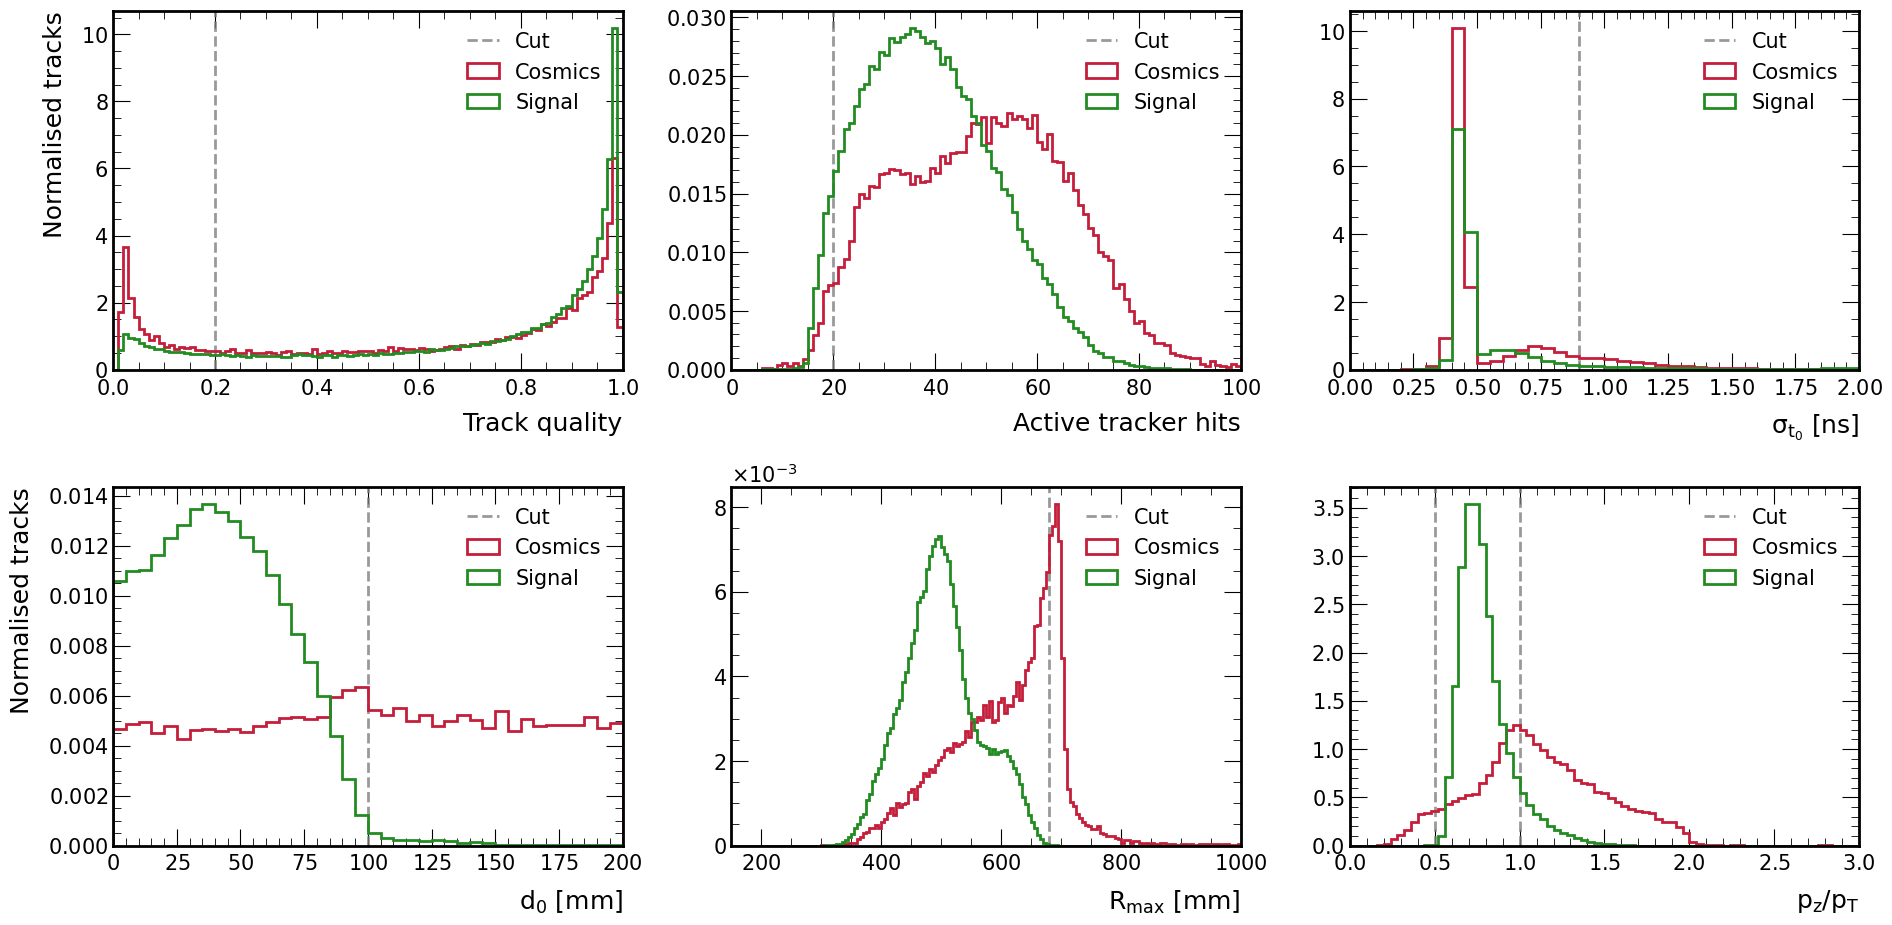

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(3*6.4, 2*4.8))

styles = {
    datasets[0] : {"color": "#C41E3A", "linewidth" : 2.0},
    # datasets[0] : {"color": "#C41E3A"}, # , "linestyle": "--"},
    # datasets[0] : {"color": "#228B22", "histtype": "bar"},
    # datasets[2] : {"color": "#228B22"},
    datasets[1] : {"color": "#228B22", "linewidth" : 2.0} #  "histtype": "bar"},
    # datasets[5] : {"color": "#228B22", "linestyle": "--"}
}

if True:
    # trkqual
    ax[0, 0].axvline(0.2, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # nactive
    ax[0, 1].axvline(20, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # t0err
    ax[0, 2].axvline(0.9, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # d0
    ax[1, 0].axvline(100, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # Rmax
    ax[1, 1].axvline(680, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # pitch
    ax[1, 2].axvline(0.5, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    ax[1, 2].axvline(1.0, linestyle="--", color="grey", alpha=0.8, linewidth=2.0)

plotter.plot_1D_overlay(
    trkqual,
    nbins=100,
    xmin=0,
    xmax=1,
    xlabel="Track quality",
    ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    leg=True,
    show=False,
    ax=ax[0,0],
    log_y=False
)

plotter.plot_1D_overlay(
    nactive,
    nbins=100,
    xmin=0,
    xmax=100,
    xlabel="Active tracker hits",
    # ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[0,1],
    log_y=False
)

plotter.plot_1D_overlay(
    t0err,
    nbins=100,
    xmin=0,
    xmax=5,
    xlabel=r"$\sigma_{t_{0}}$ [ns]",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[0,2],
    log_y=False
)

ax[0,2].set_xlim(0, 2)

plotter.plot_1D_overlay(
    d0,
    nbins=40,
    xmin=0,
    xmax=200,
    xlabel=r"$d_{0}$ [mm]",
    ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[1,0],
    log_y=False
)

plotter.plot_1D_overlay(
    lhr_max,
    nbins=170,
    xmin=150,
    xmax=1000,
    xlabel=r"$R_{\text{max}}$ [mm]",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[1,1],
    log_y=False
)

plotter.plot_1D_overlay(
    pitch_angle,
    nbins=75,
    xmin=0,
    xmax=3.0,
    xlabel=r"$p_{z}/p_{T}$", 
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[1,2],
    log_y=False
)




plt.tight_layout()
out_path = "../../output/images/comp/h1o_3x2_trk_params_au_simple.png"
plt.savefig(out_path, dpi=300)
logger.log(f"\tWrote {out_path}", "success")
plt.show()

[pylogger] ✅ 	Wrote ../../output/images/comp/h1o_2x3_trk_params_au_simple.png


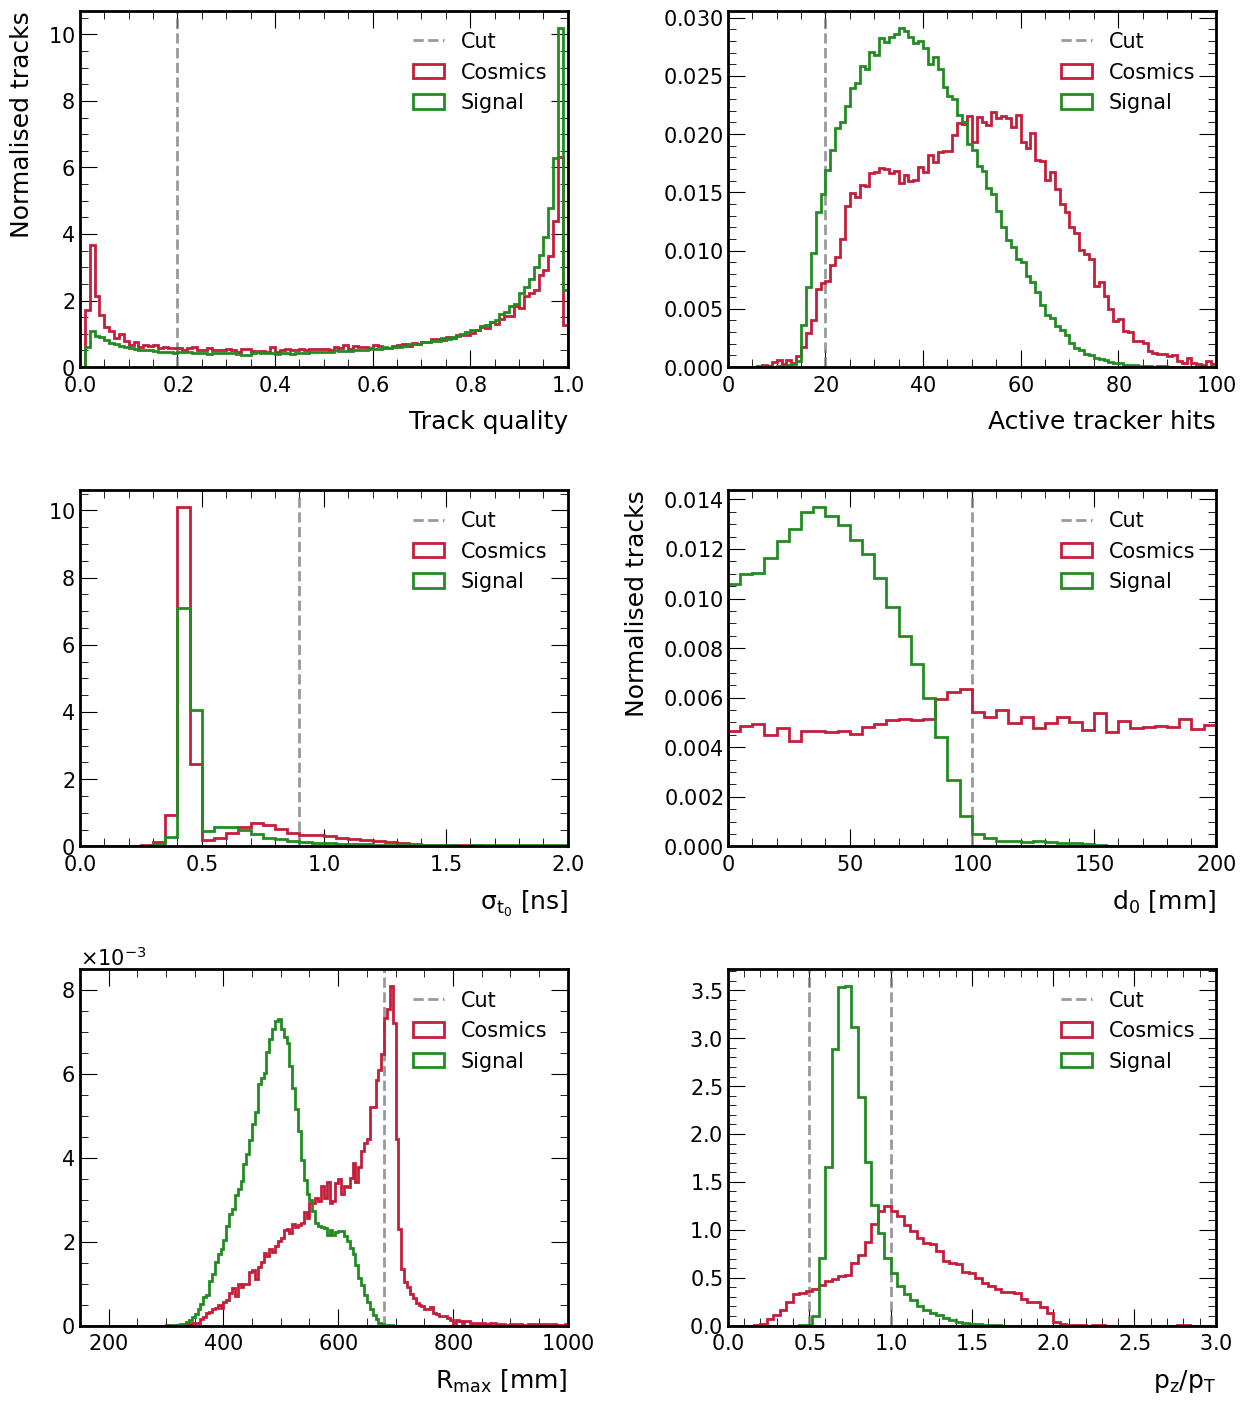

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(2*6.4, 3*4.8))

styles = {
    datasets[0] : {"color": "#C41E3A", "linewidth" : 2.0},
    # datasets[0] : {"color": "#C41E3A"}, # , "linestyle": "--"},
    # datasets[0] : {"color": "#228B22", "histtype": "bar"},
    # datasets[2] : {"color": "#228B22"},
    datasets[1] : {"color": "#228B22", "linewidth" : 2.0} #  "histtype": "bar"},
    # datasets[5] : {"color": "#228B22", "linestyle": "--"}
}

if True:
    # Row 0
    ax[0, 0].axvline(0.2, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    ax[0, 1].axvline(20, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # Row 1  
    ax[1, 0].axvline(0.9, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    ax[1, 1].axvline(100, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    # Row 2
    ax[2, 0].axvline(680, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    ax[2, 1].axvline(0.5, linestyle="--", color="grey", alpha=0.8, linewidth=2.0, label="Cut")
    ax[2, 1].axvline(1.0, linestyle="--", color="grey", alpha=0.8, linewidth=2.0)

plotter.plot_1D_overlay(
    trkqual,
    nbins=100,
    xmin=0,
    xmax=1,
    xlabel="Track quality",
    ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    leg=True,
    show=False,
    ax=ax[0,0],
    log_y=False
)

plotter.plot_1D_overlay(
    nactive,
    nbins=100,
    xmin=0,
    xmax=100,
    xlabel="Active tracker hits",
    # ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[0,1],
    log_y=False
)

plotter.plot_1D_overlay(
    t0err,
    nbins=100,
    xmin=0,
    xmax=5,
    xlabel=r"$\sigma_{t_{0}}$ [ns]",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[1,0],
    log_y=False
)

ax[1,0].set_xlim(0, 2)

plotter.plot_1D_overlay(
    d0,
    nbins=40,
    xmin=0,
    xmax=200,
    xlabel=r"$d_{0}$ [mm]",
    ylabel="Normalised tracks",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[1,1],
    log_y=False
)

plotter.plot_1D_overlay(
    lhr_max,
    nbins=170,
    xmin=150,
    xmax=1000,
    xlabel=r"$R_{\text{max}}$ [mm]",
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[2,0],
    log_y=False
)

plotter.plot_1D_overlay(
    pitch_angle,
    nbins=75,
    xmin=0,
    xmax=3.0,
    xlabel=r"$p_{z}/p_{T}$", 
    # title=suface_name,
    styles=styles,
    norm_by_area=True,
    # leg=False,
    show=False,
    ax=ax[2,1],
    log_y=False
)




plt.tight_layout()
out_path = "../../output/images/comp/h1o_2x3_trk_params_au_simple.png"
plt.savefig(out_path, dpi=300)
logger.log(f"\tWrote {out_path}", "success")
plt.show()

[pylogger] ✅ 	Wrote ../../output/images/comp/h1o_pitch_vs_rmax_box.png


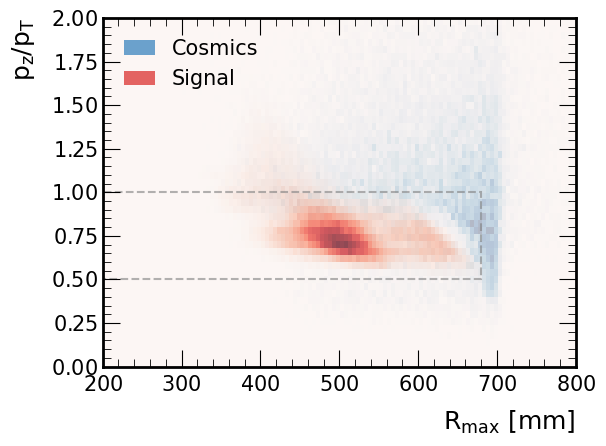

In [15]:
fig, ax = plt.subplots() # 2, 3, figsize=(3*6.4, 2*4.8))

from matplotlib.patches import Rectangle

# Create a rectangle patch
box = Rectangle((0, 0.5), 680, 0.5, 
                linewidth=1.5, edgecolor="grey", facecolor='none', alpha=0.6, linestyle="--", label="Cut")
ax.add_patch(box)

plotter.plot_2D_overlay(
    # First dataset (cosmic)
    x1=lhr_max["Cosmics"],
    y1=pitch_angle["Cosmics"],
    # Second dataset (signal)
    x2=lhr_max["Signal"],
    y2=pitch_angle["Signal"],
    # Binning
    nbins_x=170, xmin=150, xmax=1000,
    nbins_y=75, ymin=0, ymax=3,
    # Styling
    cmap1="Blues", cmap2="Reds", #, alpha=0.3,
    labels=["Cosmics", "Signal"],
    # Labels
    xlabel=r"$R_{\text{max}}$ [mm]",
    ylabel=r"$p_{z}/p_{T}$",
    show=False, 
    leg_pos="upper left",
    # leg=False,
    ax=ax
)


# Rmax
# ax.axvline(680, linestyle="--", color="grey", alpha=0.8, linewidth=1.5)
# # pitch
# ax.axhline(0.5, linestyle="--", color="grey", alpha=0.8, linewidth=1.5) 
# ax.axhline(1.0, linestyle="--", color="grey", alpha=0.8, linewidth=1.5)

# # Your existing lines
# ax.axvline(680, linestyle="--", color="grey", alpha=0.8, linewidth=1.5)
# ax.axhline(0.5, linestyle="--", color="grey", alpha=0.8, linewidth=1.5) 
# ax.axhline(1.0, linestyle="--", color="grey", alpha=0.8, linewidth=1.5)



ax.set_xlim(200, 800)
ax.set_ylim(0, 2.0)

plt.tight_layout()
out_path = "../../output/images/comp/h1o_pitch_vs_rmax_box.png"
plt.savefig(out_path, dpi=300)
logger.log(f"\tWrote {out_path}", "success")
# Add the missing vertical line to complete the box
# ax.axvline(x_right_boundary, linestyle="--", color="grey", alpha=0.8, linewidth=1.5)

plt.show()

